## ROC曲線を描く
真陽性率(TPR)と偽陽性率(FPR)を軸に取り、左上隅に最も近いモデルが優秀な分類器とされる  
曲線下面積AUCを実際の評価では使うので、sklearnのroc_auc_scoreで簡単に求めることもできる

## データ準備

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import urllib
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                     '/breast-cancer-wisconsin/wdbc.data', header=None)
except urllib.error.URLError:
    df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                     'python-machine-learning-book/master/code/'
                     'datasets/wdbc/wdbc.data', header=None)
print('rows, columns:', df.shape)
display(df.head())

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
X=df.iloc[:,2:]
y=df.iloc[:,1]
le=LabelEncoder()
y=le.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
# ROC曲線の見た目を面白くするために意図的に特徴量を減らしてみる
X_train2=X_train.iloc[:,[1,11]]

rows, columns: (569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


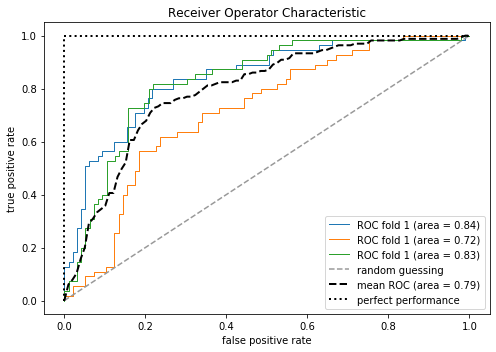

In [20]:
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# モデル作成
pipe_lr=Pipeline([('sc',StandardScaler()),('pca',PCA(n_components=2)),('lr',LogisticRegression(penalty='l2',C=100,random_state=1))])

# 交差分割検証のインスタンス
cv=StratifiedKFold(n_splits=3,random_state=1)

# ここから描画の処理
fig=plt.figure(figsize=(7,5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for train,test in cv.split(X_train2,y_train):
# predic_probaで確率を予測
    probas = pipe_lr.fit(X_train2.iloc[train],
                         y_train[train]).predict_proba(X_train2.iloc[test])
    
# sklearnのroc_curver関数で、FPR,TPR,しきい値を取得
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
# auc関数で曲線下面積を計算
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
# あて推量をプロット
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# FPR,TPR,RPC,AUCをそれぞれの平均をプロット
mean_tpr /=cv.n_splits
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
# 予測が正解したときにROC曲線をプロット
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()